## Effects of changing parameters

Example using a 800 x 500 x 1 grid. Steady state. MG, connected and disconnected field.
2D. PARTICLE TRACKING.
MULTIPLE SIMULTIONS.

## Housekeeping

In [1]:
import os
import sys
import numpy as np
import scipy as sp
from scipy.special import erf, erfinv
import pylab as plt
import flopy as fp
import subprocess as sup
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import pandas as pd

print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(fp.__version__))

flopy is installed in C:\Users\19904604\Anaconda3\lib\site-packages\flopy
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


## Running K field simulations

In [2]:
def SGSIM_input_write(nx,ny,nz,nr,dx,dy,dz,corrx,corry,corrz):
    f = open('sgsim.in','w')
    f.write('              Parameters for SGSIM\n')
    f.write('             ********************\n')
    f.write('                        \n')
    f.write('START OF PARAMETERS:\n')
    f.write('dummy.day \n')  
    f.write('%i %i %i %i %i %i\n' % (1,2,0,3,5,0))
    f.write('%g %g \n' % (-1.,1.e21))
    f.write('%i \n' % 0)
    f.write('%s \n' % ('sgsim.trn' ))
    f.write('%i \n' % 0)
    f.write('%s \n' % ('histsmth.out'))
    f.write('%i %i \n' % (1,2))
    f.write('%g %g \n' % (-1.e21,1.e21))
    f.write('%i %g \n' % (1,1.))
    f.write('%i %g \n' % (1,1.))
    f.write('%i \n' %2)
    f.write('%s \n' % ('debug.dat'))
    f.write('%s \n' % ('sgsim.out'))
    f.write('%i \n' % (nr))
    f.write('%i %g %g\n' % (nx,dx/2.,dx))
    f.write('%i %g %g\n' % (ny,dy/2.,dy))
    f.write('%i %g %g\n' % (nz,dz/2.,dz))
    f.write('%i\n' % (np.random.randint(1000)))
    f.write('%i %i \n' % (0,8))
    f.write('%i \n' % (12))
    f.write('%i \n' % (1))
    f.write('%i %i \n' % (1,3))
    f.write('%i \n' % (0))
    f.write('%g %g %g\n'%(corrx*3,corry*3.,corrz*3.))
    f.write('%g %g %g\n'%(0.,0.,0.))
    f.write('%i %i %i \n' %(51,51,11))                
    f.write('%i %g %g\n' % (0,0.6,1.0))
    f.write(' dummy2.dat                \n')
    f.write('%i \n' % (4))
    f.write('%i %g\n' % (1,0.))
    f.write('%i %g %g %g %g\n' % (1,1.0,0.,0.,0.))
    f.write('%g %g %g\n'%(corrx,corry,corrz))
    f.close()

In [3]:
ncol = 800
nrow = 500
nlay = 1
nr = 9
dx = 1.
dy = 1.
dz = 1.
corrx = 9.
corry = 9.
corrz = 9.
SGSIM_input_write(ncol,nrow,nlay,nr,dx,dy,dz,corrx,corry,corrz)

In [4]:
sup.run('sgsim sgsim.in',shell = True)

CompletedProcess(args='sgsim sgsim.in', returncode=0)

In [5]:
# These arrays are in normalised logarithms
MG = np.loadtxt('sgsim.out',skiprows = 3).reshape((nr,nlay,nrow,ncol))
Zinn = abs(MG)
Zinn = np.sqrt(2.)*erfinv(2*erf(Zinn/np.sqrt(2.))-1.)
Zinn_discon=Zinn[:,:,0:268,0:429]
Zinn_con = -Zinn_discon

In [6]:
print(Zinn_con.shape)

(9, 1, 268, 429)


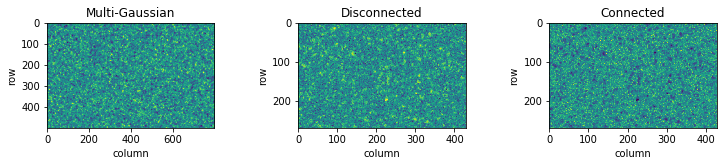

In [7]:
plt.figure(figsize = (12,12))

plt.subplot(1,3,1)
plt.imshow(MG[0,0,:,:],vmin=-4,vmax=4) 
plt.xlabel('column') #Label the x-axis
plt.ylabel('row') #label the y-axis
plt.title('Multi-Gaussian')

plt.subplot(1,3,2)
plt.imshow(Zinn_discon[0,0,:,:],vmin=-4,vmax=4) 
plt.xlabel('column') #Label the x-axis
plt.ylabel('row') #label the y-axis
plt.title('Disconnected')

plt.subplot(1,3,3)
plt.imshow(Zinn_con[0,0,:,:],vmin=-4,vmax=4) 
plt.xlabel('column') #Label the x-axis
plt.ylabel('row') #label the y-axis
plt.title('Connected')

#plt.colorbar(shrink=0.5)

plt.subplots_adjust(wspace = 0.5)

In [8]:
print('Normalised MG mean is %.3f and variance is %.3f' %(np.mean(MG[0,:,:,:]),np.var(MG[0,:,:,:])))
print('Normalised disconnected mean is %.3f and variance is %.3f' %(np.mean(Zinn_discon[0,:,:,:]),np.var(Zinn_discon[0,:,:,:])))
print('Normalised connected mean is %.3f and variance is %.3f' %(np.mean(Zinn_con[0,:,:,:]),np.var(Zinn_con[0,:,:,:])))

Normalised MG mean is -0.003 and variance is 1.024
Normalised disconnected mean is 0.010 and variance is 1.002
Normalised connected mean is -0.010 and variance is 1.002


In [9]:
# Defining lnK mean and standard deviations
#lnK_max = 1.                          # 2.7 m/day
#lnK_min = -5.                         # 0.0067 m/day 
#lnK_mean = (lnK_max + lnK_min) / 2    # Assumes a symmetrical bell curve
#lnK_std = abs(lnK_max - lnK_min) / 6  # Assumes max is 3 std devs from mean

lnK_mean = -2.
lnK_std = 1.

In [10]:
#K_max = np.exp(lnK_max)
#K_min = np.exp(lnK_min)
K_mean = np.exp(lnK_mean)
K_std = np.exp(lnK_std)

print('Mean lnk = %.3f' %lnK_mean)
print('Std of lnK = %.3f' %lnK_std)
print('Variance of lnk = %.3f' %lnK_std**2)
print('Actual mean K = %.3f' %K_mean)
print('Actual std dev K = %.3f' %K_std)

Mean lnk = -2.000
Std of lnK = 1.000
Variance of lnk = 1.000
Actual mean K = 0.135
Actual std dev K = 2.718


Now to convert log K to actual K using:
\begin{equation}
K_{act} = \exp\left(\ln(K_{\mu}) + K_{\mu=0,\sigma^2=1} \times \sqrt{\sigma^2_{act}}  \right)
\end{equation}
where $K_{act}$ is the K field with desired properties, $K_{\mu}$ is the desired mean hydraulic conductivity of the field, $K_{\mu=0,\sigma^2=1}$ is the starting field with zero mean and unit variance, and $\sigma^2_{act}$ is the variance of the field.

I have used log 10 instead of natural log. I don't think this should matter as long as I am consistent. I like to use it as it's easier to see what log K represents when K is in scientific notation.


In [11]:
# Creating actual K fields
Kh_MG = np.exp(np.log(K_mean) + MG[:,:,:,:] * np.sqrt(K_std ** 2))
Kh_con = np.exp(np.log(K_mean) + Zinn_con[:,:,:,:] * np.sqrt(K_std ** 2))
Kh_discon = np.exp(np.log(K_mean) + Zinn_discon[:,:,:,:] * np.sqrt(K_std ** 2))

In [12]:
print(np.max(Kh_MG))
print(np.min(Kh_MG))

49894.88985979565
3.642557685153534e-07


In [13]:
print('Arithmetic MG mean is %.3f m/day and variance is %.3f' %(np.mean(Kh_MG[0,0,:,:]),np.var(Kh_MG[0,0,:,:])))
print('Arithmetic disconnected mean is %.3f m/day and variance is %.3f' %(np.mean(Kh_discon[0,0,:,:]),np.var(Kh_discon[0,0,:,:])))
print('Arithmetic connected mean is %.3f m/day and variance is %.3f\n' %(np.mean(Kh_con[0,0,:,:]),np.var(Kh_con[0,0,:,:])))
        
print('Geometric MG mean is %.3f m/day' %(np.exp(np.mean(np.log(Kh_MG[0,0,:,:])))))
print('Geometric disconnected mean is %.3f m/day' %(np.exp(np.mean(np.log(Kh_discon[0,0,:,:])))))
print('Geometric connected mean is %.3f m/day' %(np.exp(np.mean(np.log(Kh_con[0,0,:,:])))))

Arithmetic MG mean is 5.870 m/day and variance is 20653.681
Arithmetic disconnected mean is 5.657 m/day and variance is 8976.283
Arithmetic connected mean is 5.558 m/day and variance is 13916.732

Geometric MG mean is 0.134 m/day
Geometric disconnected mean is 0.139 m/day
Geometric connected mean is 0.132 m/day


# Displaying 9 realisations of connected field

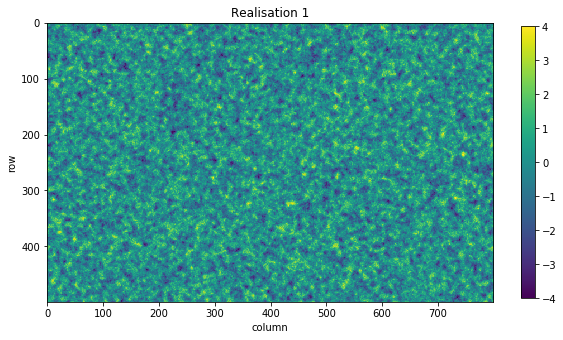

In [14]:
plt.figure(figsize = (10,10))

for i in range(1):
    plt.subplot(1,1,i+1)
    plt.imshow(MG[i,0,:,:],vmin = -4., vmax = 4.) #Show the kfield
    plt.xlabel('column') #Label the x-axis
    plt.ylabel('row') #label the y-axis
    plt.title('Realisation ' + str(i+1))
    plt.colorbar(shrink = 0.5)
plt.subplots_adjust(wspace = 0.5)

## Initialise Model

In [15]:
precision = 'single' # or 'double'
dtype = np.float32 # or np.float64

name = 'Experimental'
mf = fp.modflow.Modflow(modelname=name, exe_name='mf2005', version='mf2005')

#Grid dimensions (DIS)
ncol = 429
nrow = 268
nlay = 1
Lx = 800.
Ly = 500.
H = 1.
ztop = 0.
zbot = -H
bot = np.linspace(-H/nlay, -H, nlay)
delr = Lx / ncol #distance along the columns
delc = Ly / nrow # distance along the rows.
delz = (ztop - zbot) / nlay

NPER = 1 #Number of stress Periods
Perlen = [10.]
TSMULT = [1.0]
NSTP = [1] #number of time steps foreach period
STEADY =[True] #A bool list, with "True"for steady state stress periosd, and "False"for transient

itmuni = 4 #This is the time uint, 4 is days
lenuni = 2 #This is the length unit. 2 is meters

dis = fp.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=bot)

#Initial and boundary conditions (BAS)
IBOUND = np.ones((nlay,nrow,ncol),dtype=np.int32)
IBOUND[:,:,0] = -1  # Constant head left
IBOUND[:,:,-1] = -1 # Constand head right

#Next we specify the heads for the start of the silulation
h1 = 100.
h2 = 80.
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = h1
strt[:, :, -1] = h2

bas = fp.modflow.ModflowBas(mf, ibound=IBOUND, strt=strt)

#Specify Output (OC)
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
spd[(0,0)]
oc = fp.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

#Solver file
pcg = fp.modflow.ModflowPcg(mf,iter1=10000)

In [16]:
print(strt.shape)

(1, 268, 429)


## Running MODFLOW

In [17]:
heads_all = np.zeros((nr,nlay,nrow,ncol))
times_all = np.zeros((nr,nlay,nrow,ncol))
head_all = np.zeros((nr,nlay,nrow,ncol))
FRF_all = []
FFF_all = []
CH_all = []

for i in range(nr):
    Kh_temp = Kh_con[i,:,:,:]
    lpf = fp.modflow.ModflowLpf(mf, hk=Kh_temp, vka=Kh_temp, ipakcb=53)
    mf.write_input()
    sup.run('mf2005 Experimental',shell = True)
     
    hds = bf.HeadFile(name+'.hds') 
    heads = hds.get_data(totim=1.0)
    times = hds.get_times()
    head = hds.get_data(totim=times[-1])
    cbc = fp.utils.binaryfile.CellBudgetFile(name+'.cbc') 
    FRF = cbc.get_data(kstpkper=(0,0), text='FLOW RIGHT FACE')[0]
    FFF = cbc.get_data(kstpkper=(0,0), text='FLOW FRONT FACE')[0]
    CH = cbc.get_data(kstpkper=(0,0), text='CONSTANT HEAD')[0]
    
    print(heads.shape)
    heads_all[i,:,:,:] = heads
    times_all[i,:,:,:] = times
    head_all[i,:,:,:] = head
    FRF_all.append(FRF)
    FFF_all.append(FFF)
    CH_all.append(CH)

(1, 268, 429)
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
(1, 268, 429)
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
(1, 268, 429)
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
(1, 268, 429)
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
(1, 268, 429)
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
(1, 268, 429)
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.Modfl

In [18]:
print(type(heads_all)) 
print(heads_all.shape) 
print(type(CH_all[0]))
print(len(CH_all[0]))
print(type(FRF_all[0]))
print(len(FRF_all[0]))
print(type(FFF_all[0]))
FFF_1 = FFF_all[0]
print(len(FFF_1))
print(FFF_1.shape)

<class 'numpy.ndarray'>
(9, 1, 268, 429)
<class 'numpy.recarray'>
536
<class 'numpy.ndarray'>
1
<class 'numpy.ndarray'>
1
(1, 268, 429)


# Create plot of heads

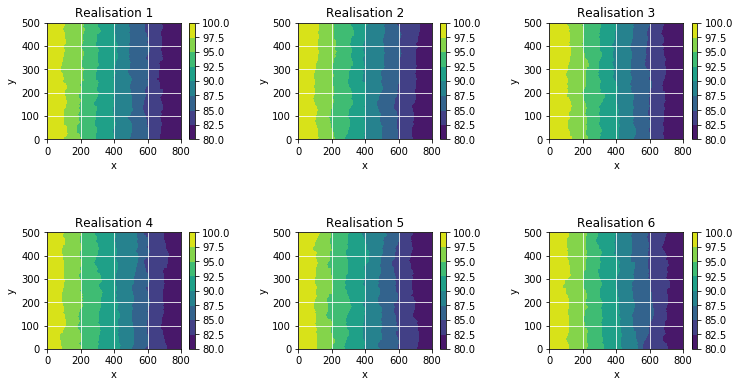

In [19]:
plt.figure(figsize = (12,6))
x = np.linspace(0, Lx, ncol)
y = np.linspace(0, Ly, nrow)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.contourf(x, y, heads_all[i,0,:,:])
    plt.xticks(np.arange(min(x), max(x)+1, 200.))
    plt.yticks(np.arange(min(y), max(y)+1, 100.))
    plt.title('Constant Head')
    plt.xlabel('x'); plt.ylabel('y')
    plt.grid(True,color='w')
    plt.title('Realisation ' + str(i+1))
    plt.colorbar()
plt.subplots_adjust(wspace = 0.5,hspace=0.8)


## Particle Tracking

In [20]:
def Dget(vx,vy,al,at,Deff):
    D = np.zeros((2,2))
    v = np.sqrt(vx**2 + vy**2)
    D[0,0] = (al-at)*vx**2/v + at*v +Deff    #Dxx
    D[1,1] = (al-at)*vy**2/v + at*v +Deff    #Dyy   
    D[0,1] = (al-at)*vx*vy/v                 #Dxy 
    D[1,0] = (al-at)*vy*vx/v                 #Dyx
    return(D)

class part:
    def __init__(self,x0,y0,aL,aT,Deff):
        self.x = x0
        self.y = y0
        self.aL = aL
        self.aT = aT
        self.Deff = Deff
        self.t = 0.
        
    def move(self,x1,x2,y1,y2,vx1,vx2,vy1,vy2,dt):
        # we will use the ito Fokker Planck method to move te particles.
        # we first calculate the dispersion tesor at the centre of each face for the Gradient term:
        Dx1 = Dget(vx1,(vy1+vy2)/2,self.aL,self.aT,self.Deff)
        Dx2 = Dget(vx2,(vy1+vy2)/2,self.aL,self.aT,self.Deff)
        Dy1 = Dget((vx1+vx2)/2.,vy1,self.aL,self.aT,self.Deff)
        Dy2 = Dget((vx1+vx2)/2.,vy2,self.aL,self.aT,self.Deff)

        #Then we calculate the drift vertoe
        fx = (self.x-x1)/(x2-x1)
        vx = (1-fx)*vx1 + fx*vx2
        fy = (self.y-y1)/(y2-y1)
        vy = (1-fy)*vy1 + fy*vy2
        A= np.zeros(2)
        A[0] = vx1 + (Dx2[0,0]-Dx1[0,0])/(x2-x1) + (Dy2[1,0]-Dy1[1,0])/(y2-y1)
        A[1] = vy1 + (Dx2[0,1]-Dx1[0,1])/(x2-x1) + (Dy2[1,1]-Dy1[1,1])/(y2-y1)
        
        #Then the random vector
        B = np.zeros((2,2))
        v = np.sqrt(vx**2 + vy**2)
        B[0,0] = vx/v*np.sqrt(2*(v*self.aL+self.Deff))
        B[0,1] = -vx/v*np.sqrt(2*(v*self.aT+self.Deff))
        B[1,0] = -vy/v*np.sqrt(2*(v*self.aT+self.Deff))
        B[1,1] = vy/v*np.sqrt(2*(v*self.aL+self.Deff))          
        err = np.random.normal(0,1,2)
        
        #move the particle
        dX = A*dt + np.dot(B,err)*np.sqrt(dt)
        self.x += dX[0]
        self.y += dX[1]
        self.t += dt

In [21]:
dt = 0.1     # set the timestep
ndays = 100  # number of days is 100
por = 0.1    # set the porosity
npart = 100  # number of particles to be released

x0 = 100. #set the starting x-location
y0 = 100. #set the starting y-direction
aL = 0.01 #set the longitudinal dispersivity
aT = 0.01 #set the Transverse dispersivity
Deff = 0.0001 #set the effective difusion coefficient


In [22]:
Part_all_x = np.zeros((npart,nr)) 
Part_all_y = np.zeros((npart,nr))

for i in range(nr):
    FRF = FRF_all[i]
    FFF = FFF_all[i] 
    Part=[]
    for n in range(npart): #we are looking over 2000 entries
        Part.append(part(x0,y0,aL,aT,Deff)) #Add a particle object to the list
 
    for k in range(int(ndays/dt)): #Loop over the timesteps
            for j in range(npart):
                #Locate the particle
                #cdum is the colum the particle is located
                cdum = int(Part[j].x/delr) #we can just use the integer value for the location
                #rdum is the row the particle is located in
                rdum = nrow - int(Part[j].y/delr) -1 #we need to reverse it as the highest y value relates to the lowest column number
                vx2 = FRF[0,rdum,cdum]/por #the right face of the cell corresponds to vx2
                if cdum >0:
                    vx1 = FRF[0,rdum,cdum-1]/por # we need to use the sell one column before for vx1
                else:
                    vx1 = 0. #unless there isn't a cell behind us
                vy1 = -FFF[0,rdum,cdum]/por #A positive flow through the front face would be the correct dorection in the vy1
                if rdum >0:
                    vy2 = -FFF[0,rdum-1,cdum]/por #vy2 corresponds to the prefios row, which has a higher y-value
                else:
                    vy2 = 0.
                Part[j].move(float(cdum),float(cdum+1),float(nrow-1) - float(rdum),float(nrow) - 
                       float(rdum),vx1,vx2,vy1,vy2,dt)
                #These vext commanjs just reflcet the particles at the y no-flow boundaries.
                if Part[j].y<0.:
                    Part[j].y = -Part[j].y
                elif Part[j].y>nrow:
                    Part[j].y = ncol-Part[j].y
                #print('Realisation' + str(i) + ', Timestep ' + str(k))              
                Part_all_x[j][i]=Part[j].x
                Part_all_y[j][i]=Part[j].y
    

# Particle tracking

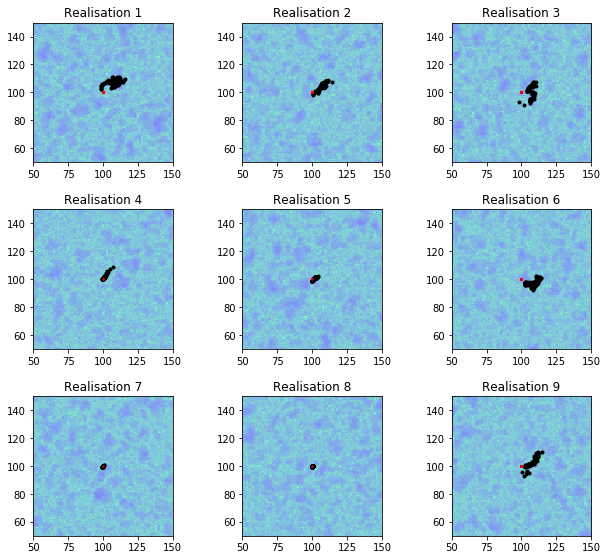

In [23]:
fig = plt.figure(figsize = (10,10))
for i in range(nr):
    plt.subplot(3,3,i+1)
    plt.imshow((Zinn_con[i,0,:,:]),cmap='winter',vmin = -4, vmax = 4.,alpha=0.5)
    plt.xlim(50,150)
    plt.ylim(50,150)
    plt.title('Realisation ' + str(i+1))
    for j in range(npart):
        plt.plot(Part_all_x[j][i],Part_all_y[j][i],'ko',ms = 3)
        plt.plot(x0,y0,'ro',ms = 1)
plt.subplots_adjust(wspace = 0.5,hspace=0.1)

In [24]:
movement_max =[]
movement_min = []
movement_average = []
for i in range(nr):
    movement_max.append(Part_all_x[:][i].max()-100.)
    movement_min.append(Part_all_x[:][i].min()-100.)
    movement_average.append(Part_all_x[:][i].mean()-100.)
    
print(movement_max)
print('Average max movement = %0.4f m' % np.mean(movement_max))
print('Average min movement = %0.4f m' % np.mean(movement_min))
print('Average mean movement = %0.4f m' % np.mean(movement_average))

[10.72872972701721, 11.786958626631872, 13.040915079927501, 10.426641503294803, 11.262623827377453, 10.715470243218945, 11.682624269164748, 11.689962907312548, 13.048020482306129]
Average max movement = 11.5980 m
Average min movement = -0.0143 m
Average mean movement = 4.5624 m


## Investigating cell budgets

In [25]:
print(type(CH_all))
print(len(CH_all))
#print(CH) #This comes from the .cbc file. CH is a list with (array,array,array...)

<class 'list'>
9


In [26]:
#Reading output files and calculating effective conductivity
Keff=[]

for i in range(nr):
    Q = 0.
    for j in range(len(CH_all[i])): #CH[0] is the array in the CH list
        if CH_all[i][j][1]>0: #we are querying if the second number in the tupple is positive
            Q+= CH_all[i][j][1] #then if it is we add it to our flow value    

    Keff_temp = Q*Lx/(Ly*(ztop-zbot)*(h1 - h2))
    Keff.append(Keff_temp)
    print('Keff for Realisation ' + str(i+1) + ' = %0.4f m/day' % Keff_temp)
    
print('Average Keff = %0.4f m' % np.mean(Keff))

Keff for Realisation 1 = 0.1291 m/day
Keff for Realisation 2 = 0.1340 m/day
Keff for Realisation 3 = 0.1298 m/day
Keff for Realisation 4 = 0.1340 m/day
Keff for Realisation 5 = 0.1282 m/day
Keff for Realisation 6 = 0.1373 m/day
Keff for Realisation 7 = 0.1351 m/day
Keff for Realisation 8 = 0.1382 m/day
Keff for Realisation 9 = 0.1312 m/day
Average Keff = 0.1330 m
